In [1]:
import copy
import json
from datetime import datetime
from typing import TypedDict

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from constants import DATA_DIR, MODELS_DIR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import (
    PackedSequence,
    pack_padded_sequence,
    pad_packed_sequence,
    pad_sequence,
)
from torch.utils.data import DataLoader, Dataset, TensorDataset

from astrofit.utils import AsteroidLoader, LightcurveBinner

sns.set_theme(style="darkgrid")
plt.rcParams["figure.figsize"] = (14, 6)

In [2]:
assert torch.cuda.is_available(), "CUDA is not available"

In [3]:
asteroid_loader = AsteroidLoader(DATA_DIR)
lightcurve_binner = LightcurveBinner()

ASTEROIDS_FREQ_DATA_PATH = DATA_DIR / "asteroids_freq_data.json"


In [4]:
with open(ASTEROIDS_FREQ_DATA_PATH, "r") as f_in:
    asteroids_data = json.load(f_in)

filtered_data = {name: data for name, data in asteroids_data["asteroids"].items() if not data["is_failed"]}
len(filtered_data)

2662

In [16]:
asteroids_data["config"]

{'max_hours_diff': 24,
 'min_no_points': 10,
 'top_k_bins': 4,
 'buffer_bins': 3,
 'select_bins_by': 'points',
 'max_time_diff': 45,
 'min_bin_size': 1,
 'max_freq': 12,
 'top_k_freqs': 50,
 'nterms': 3,
 'max_debug': False}

In [5]:
X_data = []
y_data = []
for data in filtered_data.values():
    X_data.append(torch.tensor(data["freq_features"]))
    y_data.append(data["period"])

y_data = torch.tensor(y_data).unsqueeze(1)

In [15]:
# Histogram of periods using plotly
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=y_data.flatten(), histnorm="probability"))
fig.update_layout(title_text="Histogram of periods")

fig.show()


In [6]:
def get_packed_padded_data(data: list[torch.Tensor]):
    seq_len = torch.tensor([len(x) for x in data])
    
    padded = pad_sequence(data, batch_first=True)
    print(f"Padded shape: {padded.shape}")
    
    packed =  pack_padded_sequence(padded, seq_len, batch_first=True, enforce_sorted=False)
    print(f"Packed data shape: {packed.data.shape}")

    return packed

In [7]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X_data, y_data, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.3, random_state=42)
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 1863
Validation size: 559
Test size: 240


In [8]:
y_train.shape

torch.Size([1863, 1])

In [9]:
X_train = get_packed_padded_data(X_train)
X_val = get_packed_padded_data(X_val)
X_test = get_packed_padded_data(X_test)


Padded shape: torch.Size([1863, 4, 50])
Packed data shape: torch.Size([4235, 50])
Padded shape: torch.Size([559, 4, 50])
Packed data shape: torch.Size([1276, 50])
Padded shape: torch.Size([240, 4, 50])
Packed data shape: torch.Size([530, 50])


In [10]:
class ModelConfig(TypedDict):
    input_size: int
    hidden_size: int
    num_layers: int
    fc1_size: int
    fc2_size: int
    bidirectional: bool
    dropout: float

In [11]:
class AsteroidLSTM(nn.Module):
    def __init__(self, config: ModelConfig):
        super(AsteroidLSTM, self).__init__()
        self.hidden_size = config["hidden_size"]
        self.num_layers = config["num_layers"]
        self.bidirectional = config["bidirectional"]
        self.lstm = nn.LSTM(
            config["input_size"],
            config["hidden_size"],
            config["num_layers"],
            batch_first=True,
            bidirectional=config["bidirectional"],
            dropout=config["dropout"],
        )

        fc_input_size = config["hidden_size"] * 2 if config["bidirectional"] else config["hidden_size"]
        self.fc1 = nn.Linear(fc_input_size, config["fc1_size"])
        self.fc2 = nn.Linear(config["fc1_size"], config["fc2_size"])
        self.fc3 = nn.Linear(config["fc2_size"], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(config["dropout"])

    def forward(self, x: torch.Tensor):
        # Process the packed sequence through the LSTM
        output, _ = self.lstm(x)

        # Unpack the sequence
        output, lengths = pad_packed_sequence(output, batch_first=True)

        # Get the last output for each sequence
        batch_size = output.size(0)
        last_output = output[torch.arange(batch_size), lengths - 1]

        # If bidirectional, concatenate forward and backward last outputs
        if self.bidirectional:
            last_output = torch.cat((last_output[:, : self.hidden_size], last_output[:, self.hidden_size :]), dim=1)

        x = self.relu(self.fc1(last_output))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [12]:
class PackedSequenceDataset(Dataset):
    def __init__(self, packed_sequence, targets):
        self.data = packed_sequence
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return idx, self.targets[idx]


def custom_collate_fn(batch):
    indices, targets = zip(*batch)
    return torch.LongTensor(indices), torch.tensor(targets).float()

In [13]:
def train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size,
    num_epochs,
    learning_rate,
    model_suffix: str | None = None,
    patience=100,
):
    if model_suffix is not None:
        print(f"Training model with suffix: {model_suffix}")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Create DataLoaders
    train_dataset = PackedSequenceDataset(X_train, y_train)
    val_dataset = PackedSequenceDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    best_val_loss = float("inf")
    best_model = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for indices, y_batch in train_loader:
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            # Create a new PackedSequence for this batch
            X_batch = PackedSequence(
                X_train.data[
                    X_train.batch_sizes[: indices.max() + 1].sum()
                    - X_train.batch_sizes[: indices.max() + 1].sum() : X_train.batch_sizes[: indices.max() + 1].sum()
                ],
                X_train.batch_sizes[: indices.max() + 1],
                X_train.sorted_indices[indices],
                X_train.unsorted_indices[indices],
            )
            X_batch = X_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * y_batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for indices, y_batch in val_loader:
                y_batch = y_batch.to(device)
                # Create a new PackedSequence for this batch
                X_batch = PackedSequence(
                    X_val.data[
                        X_val.batch_sizes[: indices.max() + 1].sum()
                        - X_val.batch_sizes[: indices.max() + 1].sum() : X_val.batch_sizes[: indices.max() + 1].sum()
                    ],
                    X_val.batch_sizes[: indices.max() + 1],
                    X_val.sorted_indices[indices],
                    X_val.unsorted_indices[indices],
                )
                X_batch = X_batch.to(device)

                outputs = model(X_batch)
                loss = criterion(outputs.squeeze(), y_batch)
                val_loss += loss.item() * y_batch.size(0)

        val_loss /= len(val_loader.dataset)

        if model_suffix is not None:
            print(f"\rEpoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}", end="")

        # Check if this is the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)
            patience_counter = 0

            if model_suffix is not None:
                torch.save(best_model.state_dict(), MODELS_DIR / f"asteroid_lstm_{model_suffix}.pt")
                print(f"\nNew best model saved with validation loss: {best_val_loss:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    return best_model

In [50]:
def evaluate_model(model, X_test, y_test, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_dataset = PackedSequenceDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    model.eval()
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for indices, y_batch in test_loader:
            y_batch = y_batch.to(device)

            # Create a new PackedSequence for this batch
            X_batch = PackedSequence(
                X_test.data[
                    X_test.batch_sizes[: indices.max() + 1].sum()
                    - X_test.batch_sizes[: indices.max() + 1].sum() : X_test.batch_sizes[: indices.max() + 1].sum()
                ],
                X_test.batch_sizes[: indices.max() + 1],
                X_test.sorted_indices[indices],
                X_test.unsorted_indices[indices],
            )
            X_batch = X_batch.to(device)

            outputs = model(X_batch)

            all_outputs.extend(outputs.cpu().numpy().squeeze())
            all_targets.extend(y_batch.cpu().numpy())

    all_outputs = np.array(all_outputs)
    all_targets = np.array(all_targets)

    # Calculate metrics
    mse = mean_squared_error(all_targets, all_outputs)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(all_targets, all_outputs)
    r2 = r2_score(all_targets, all_outputs)

    print(f"Test MSE: {mse:.4f}")
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2 Score: {r2:.4f}")

    return mse, rmse, mae, r2, all_outputs, all_targets

In [51]:
config = ModelConfig(
    input_size=X_train.data.size(-1),
    hidden_size=64,
    num_layers=2,
    fc1_size=64,
    fc2_size=32,
    bidirectional=False,
    dropout=0.1,
)

In [52]:
model = AsteroidLSTM(config).cuda()
model

AsteroidLSTM(
  (lstm): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.1)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
)

In [53]:
batch_size = 16
num_epochs = 1000
learning_rate = 0.001

In [54]:
train_start = datetime.now().strftime("%Y%m%d_%H%M%S")
best_model = train_model(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size,
    num_epochs,
    learning_rate,
    model_suffix=train_start,
)

Training model with suffix: 20240824_222238
Epoch 1/1000, Train Loss: 92.0420, Val Loss: 51.0980
New best model saved with validation loss: 51.0980
Epoch 2/1000, Train Loss: 52.4723, Val Loss: 50.4042
New best model saved with validation loss: 50.4042
Epoch 3/1000, Train Loss: 52.1494, Val Loss: 50.1605
New best model saved with validation loss: 50.1605
Epoch 6/1000, Train Loss: 50.7528, Val Loss: 49.1443
New best model saved with validation loss: 49.1443
Epoch 7/1000, Train Loss: 51.1704, Val Loss: 48.7787
New best model saved with validation loss: 48.7787
Epoch 8/1000, Train Loss: 50.2029, Val Loss: 48.6727
New best model saved with validation loss: 48.6727
Epoch 9/1000, Train Loss: 49.5482, Val Loss: 48.2426
New best model saved with validation loss: 48.2426
Epoch 11/1000, Train Loss: 49.3673, Val Loss: 48.2391
New best model saved with validation loss: 48.2391
Epoch 12/1000, Train Loss: 50.1587, Val Loss: 48.1131
New best model saved with validation loss: 48.1131
Epoch 13/1000, Tra

KeyboardInterrupt: 

In [55]:
model.load_state_dict(torch.load(MODELS_DIR / f"asteroid_lstm_{train_start}.pt"))
model.eval()

mse, rmse, mae, r2, predictions, true_values = evaluate_model(model, X_test, y_test, batch_size)

Test MSE: 64.1712
Test RMSE: 8.0107
Test MAE: 5.5498
Test R2 Score: -0.0144


In [56]:
for i in range(30):
    print(f"True: {true_values[i]:8.4f}, Predicted: {predictions[i]:8.4f}")

True:  17.5418, Predicted:  10.6509
True:  13.8256, Predicted:  16.6600
True:  16.2058, Predicted:   8.2566
True:  20.6520, Predicted:  10.3694
True:   4.6544, Predicted:   8.8766
True:   5.5296, Predicted:   9.1660
True:   6.0483, Predicted:  17.1141
True:   8.8422, Predicted:   9.8479
True:   9.7250, Predicted:  10.1459
True:   3.8382, Predicted:   9.8626
True:  13.4842, Predicted:   7.9328
True:   7.6203, Predicted:   8.9874
True:   3.2556, Predicted:   7.9838
True:  12.7301, Predicted:   8.2046
True:  15.1533, Predicted:   9.3400
True:  18.1482, Predicted:  17.1302
True:   4.0120, Predicted:   8.0972
True:   3.5740, Predicted:  10.4504
True:  16.4461, Predicted:  13.9109
True:  19.9941, Predicted:  10.0037
True:  14.7956, Predicted:  16.7504
True:   3.7788, Predicted:   9.6778
True:  11.4065, Predicted:  11.0462
True:  39.0847, Predicted:   9.0827
True:   6.4109, Predicted:  16.4830
True:   3.5646, Predicted:  10.7740
True:   5.8869, Predicted:   7.9869
True:  12.1657, Predicted:  

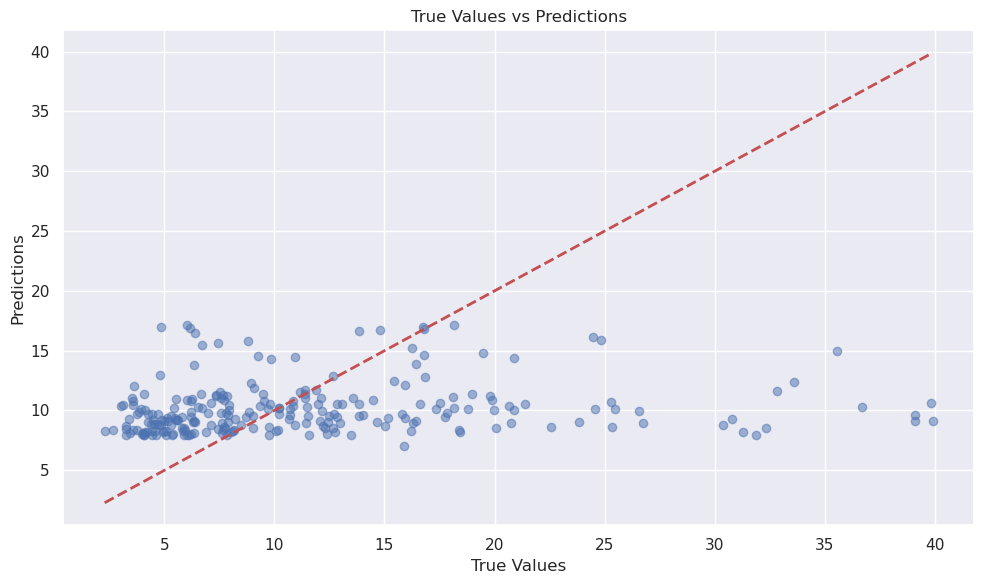

In [57]:
plt.figure(figsize=(10, 6))
plt.scatter(true_values, predictions, alpha=0.5)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.tight_layout()
plt.show()

In [58]:
import optuna
from optuna.trial import TrialState

/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
def objective(trial):
    # Define the hyperparameters to tune
    config = ModelConfig(
        input_size=50,  # Assuming this is fixed
        hidden_size=trial.suggest_int('hidden_size', 32, 256),
        num_layers=trial.suggest_int('num_layers', 1, 3),
        fc1_size=trial.suggest_int('fc1_size', 32, 256),
        fc2_size=trial.suggest_int('fc2_size', 16, 128),
        bidirectional=trial.suggest_categorical('bidirectional', [True, False]),
        dropout=trial.suggest_float('dropout', 0.1, 0.5)
    )
    
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # Create model with the suggested hyperparameters
    model = AsteroidLSTM(config)

    # Train the model
    best_model = train_model(model, X_train, y_train, X_val, y_val, batch_size, num_epochs=200, learning_rate=learning_rate)

    # Evaluate the model
    _, rmse, mae, _, _, _ = evaluate_model(best_model, X_val, y_val, batch_size)

    return rmse


In [60]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)


[I 2024-08-24 22:24:00,810] A new study created in memory with name: no-name-1a81bf31-0acd-4b52-bf0b-ebe4ab2a061e
/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1822535198925436 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:25:25,421] Trial 0 finished with value: 4.942243576049805 and parameters: {'hidden_size': 186, 'num_layers': 1, 'fc1_size': 168, 'fc2_size': 64, 'bidirectional': True, 'dropout': 0.1822535198925436, 'learning_rate': 0.00048324390639883485, 'batch_size': 16}. Best is trial 0 with value: 4.942243576049805.


Early stopping triggered after 109 epochs
Test MSE: 46.6503
Test RMSE: 6.8301
Test MAE: 4.9422
Test R2 Score: 0.0551


[I 2024-08-24 22:26:45,200] Trial 1 finished with value: 5.256509304046631 and parameters: {'hidden_size': 230, 'num_layers': 3, 'fc1_size': 253, 'fc2_size': 63, 'bidirectional': True, 'dropout': 0.1981351464570539, 'learning_rate': 0.07724841204841282, 'batch_size': 64}. Best is trial 0 with value: 4.942243576049805.


Early stopping triggered after 103 epochs
Test MSE: 49.3459
Test RMSE: 7.0247
Test MAE: 5.2565
Test R2 Score: 0.0005


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.40450533328532245 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:27:55,337] Trial 2 finished with value: 5.297974586486816 and parameters: {'hidden_size': 202, 'num_layers': 1, 'fc1_size': 160, 'fc2_size': 90, 'bidirectional': False, 'dropout': 0.40450533328532245, 'learning_rate': 0.07190885355708505, 'batch_size': 16}. Best is trial 0 with value: 4.942243576049805.


Early stopping triggered after 129 epochs
Test MSE: 49.3707
Test RMSE: 7.0264
Test MAE: 5.2980
Test R2 Score: -0.0000


[I 2024-08-24 22:30:20,543] Trial 3 finished with value: 5.29923677444458 and parameters: {'hidden_size': 236, 'num_layers': 2, 'fc1_size': 128, 'fc2_size': 117, 'bidirectional': True, 'dropout': 0.49530585234634317, 'learning_rate': 0.03764470125163319, 'batch_size': 32}. Best is trial 0 with value: 4.942243576049805.


Early stopping triggered after 143 epochs
Test MSE: 49.3707
Test RMSE: 7.0264
Test MAE: 5.2992
Test R2 Score: 0.0000


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.10521231893082206 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:31:33,401] Trial 4 finished with value: 5.142693042755127 and parameters: {'hidden_size': 120, 'num_layers': 1, 'fc1_size': 86, 'fc2_size': 87, 'bidirectional': True, 'dropout': 0.10521231893082206, 'learning_rate': 0.015337781369983537, 'batch_size': 16}. Best is trial 0 with value: 4.942243576049805.


Early stopping triggered after 131 epochs
Test MSE: 47.6706
Test RMSE: 6.9044
Test MAE: 5.1427
Test R2 Score: 0.0344


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.47599928515306356 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:32:01,648] Trial 5 finished with value: 4.943375110626221 and parameters: {'hidden_size': 117, 'num_layers': 1, 'fc1_size': 103, 'fc2_size': 61, 'bidirectional': False, 'dropout': 0.47599928515306356, 'learning_rate': 0.00018309338513670953, 'batch_size': 32}. Best is trial 0 with value: 4.942243576049805.


Early stopping triggered after 155 epochs
Test MSE: 46.4030
Test RMSE: 6.8120
Test MAE: 4.9434
Test R2 Score: 0.0601


[I 2024-08-24 22:32:22,830] Trial 6 finished with value: 4.96355676651001 and parameters: {'hidden_size': 81, 'num_layers': 2, 'fc1_size': 65, 'fc2_size': 72, 'bidirectional': False, 'dropout': 0.3016989870386404, 'learning_rate': 0.00023702171939355072, 'batch_size': 64}. Best is trial 0 with value: 4.942243576049805.


Early stopping triggered after 192 epochs
Test MSE: 45.7562
Test RMSE: 6.7643
Test MAE: 4.9636
Test R2 Score: 0.0732


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.23172632581439784 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:33:54,916] Trial 7 finished with value: 5.299153804779053 and parameters: {'hidden_size': 98, 'num_layers': 1, 'fc1_size': 228, 'fc2_size': 89, 'bidirectional': True, 'dropout': 0.23172632581439784, 'learning_rate': 0.05561111029508259, 'batch_size': 16}. Best is trial 0 with value: 4.942243576049805.


Early stopping triggered after 187 epochs
Test MSE: 49.3707
Test RMSE: 7.0264
Test MAE: 5.2992
Test R2 Score: 0.0000


[I 2024-08-24 22:35:03,923] Trial 8 finished with value: 5.299142360687256 and parameters: {'hidden_size': 165, 'num_layers': 2, 'fc1_size': 77, 'fc2_size': 120, 'bidirectional': True, 'dropout': 0.2932458103258573, 'learning_rate': 0.07608270703351003, 'batch_size': 64}. Best is trial 0 with value: 4.942243576049805.


Test MSE: 49.3707
Test RMSE: 7.0264
Test MAE: 5.2991
Test R2 Score: 0.0000


[I 2024-08-24 22:36:04,956] Trial 9 finished with value: 4.887510299682617 and parameters: {'hidden_size': 129, 'num_layers': 2, 'fc1_size': 137, 'fc2_size': 59, 'bidirectional': True, 'dropout': 0.20641148472074164, 'learning_rate': 0.00030441175568820985, 'batch_size': 32}. Best is trial 9 with value: 4.887510299682617.


Early stopping triggered after 116 epochs
Test MSE: 46.7223
Test RMSE: 6.8354
Test MAE: 4.8875
Test R2 Score: 0.0536


[I 2024-08-24 22:36:18,934] Trial 10 finished with value: 5.542545795440674 and parameters: {'hidden_size': 34, 'num_layers': 3, 'fc1_size': 194, 'fc2_size': 26, 'bidirectional': False, 'dropout': 0.10896397680901149, 'learning_rate': 1.0452534305388571e-05, 'batch_size': 128}. Best is trial 9 with value: 4.887510299682617.


Test MSE: 61.3690
Test RMSE: 7.8338
Test MAE: 5.5425
Test R2 Score: -0.2430


[I 2024-08-24 22:37:30,756] Trial 11 finished with value: 5.051861763000488 and parameters: {'hidden_size': 166, 'num_layers': 2, 'fc1_size': 164, 'fc2_size': 39, 'bidirectional': True, 'dropout': 0.18778860284647997, 'learning_rate': 0.0015396219080465014, 'batch_size': 32}. Best is trial 9 with value: 4.887510299682617.


Early stopping triggered after 106 epochs
Test MSE: 46.5860
Test RMSE: 6.8254
Test MAE: 5.0519
Test R2 Score: 0.0564


[I 2024-08-24 22:38:06,054] Trial 12 finished with value: 5.014342784881592 and parameters: {'hidden_size': 190, 'num_layers': 3, 'fc1_size': 195, 'fc2_size': 44, 'bidirectional': True, 'dropout': 0.2720619507601304, 'learning_rate': 0.0011348225884693446, 'batch_size': 128}. Best is trial 9 with value: 4.887510299682617.


Early stopping triggered after 124 epochs
Test MSE: 46.5144
Test RMSE: 6.8201
Test MAE: 5.0143
Test R2 Score: 0.0579


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.17920065319216416 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:39:24,672] Trial 13 finished with value: 4.996846675872803 and parameters: {'hidden_size': 146, 'num_layers': 1, 'fc1_size': 32, 'fc2_size': 48, 'bidirectional': True, 'dropout': 0.17920065319216416, 'learning_rate': 0.00015074061751877246, 'batch_size': 16}. Best is trial 9 with value: 4.887510299682617.


Early stopping triggered after 127 epochs
Test MSE: 46.9222
Test RMSE: 6.8500
Test MAE: 4.9968
Test R2 Score: 0.0496


[I 2024-08-24 22:39:58,192] Trial 14 finished with value: 4.848199367523193 and parameters: {'hidden_size': 62, 'num_layers': 2, 'fc1_size': 127, 'fc2_size': 19, 'bidirectional': True, 'dropout': 0.3707801524890563, 'learning_rate': 0.004831629250028658, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 118 epochs
Test MSE: 46.4885
Test RMSE: 6.8182
Test MAE: 4.8482
Test R2 Score: 0.0584


[I 2024-08-24 22:40:29,366] Trial 15 finished with value: 5.00185489654541 and parameters: {'hidden_size': 48, 'num_layers': 2, 'fc1_size': 127, 'fc2_size': 23, 'bidirectional': True, 'dropout': 0.37009719483688996, 'learning_rate': 0.005685180635147564, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 114 epochs
Test MSE: 46.5000
Test RMSE: 6.8191
Test MAE: 5.0019
Test R2 Score: 0.0581


[I 2024-08-24 22:41:25,369] Trial 16 finished with value: 4.987729072570801 and parameters: {'hidden_size': 61, 'num_layers': 2, 'fc1_size': 111, 'fc2_size': 33, 'bidirectional': True, 'dropout': 0.3596868867610109, 'learning_rate': 2.119794914900442e-05, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Test MSE: 46.4380
Test RMSE: 6.8145
Test MAE: 4.9877
Test R2 Score: 0.0594


[I 2024-08-24 22:42:12,029] Trial 17 finished with value: 4.9597978591918945 and parameters: {'hidden_size': 77, 'num_layers': 3, 'fc1_size': 141, 'fc2_size': 19, 'bidirectional': True, 'dropout': 0.4225736709573562, 'learning_rate': 0.004670548306040671, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 116 epochs
Test MSE: 45.9934
Test RMSE: 6.7818
Test MAE: 4.9598
Test R2 Score: 0.0684


[I 2024-08-24 22:42:58,283] Trial 18 finished with value: 4.935848236083984 and parameters: {'hidden_size': 112, 'num_layers': 2, 'fc1_size': 191, 'fc2_size': 50, 'bidirectional': False, 'dropout': 0.23749696433511547, 'learning_rate': 7.335386651571407e-05, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Test MSE: 46.0203
Test RMSE: 6.7838
Test MAE: 4.9358
Test R2 Score: 0.0679


[I 2024-08-24 22:43:37,440] Trial 19 finished with value: 4.909971714019775 and parameters: {'hidden_size': 90, 'num_layers': 2, 'fc1_size': 47, 'fc2_size': 100, 'bidirectional': True, 'dropout': 0.36963360816109875, 'learning_rate': 0.0032401619415223302, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 120 epochs
Test MSE: 46.2095
Test RMSE: 6.7978
Test MAE: 4.9100
Test R2 Score: 0.0640


[I 2024-08-24 22:44:14,484] Trial 20 finished with value: 5.011153697967529 and parameters: {'hidden_size': 129, 'num_layers': 3, 'fc1_size': 102, 'fc2_size': 33, 'bidirectional': True, 'dropout': 0.3035190895347676, 'learning_rate': 0.011949799700372956, 'batch_size': 128}. Best is trial 14 with value: 4.848199367523193.


Test MSE: 46.6461
Test RMSE: 6.8298
Test MAE: 5.0112
Test R2 Score: 0.0552


[I 2024-08-24 22:44:49,502] Trial 21 finished with value: 4.884944915771484 and parameters: {'hidden_size': 92, 'num_layers': 2, 'fc1_size': 34, 'fc2_size': 105, 'bidirectional': True, 'dropout': 0.3611529748144024, 'learning_rate': 0.002619709015342106, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 109 epochs
Test MSE: 46.4083
Test RMSE: 6.8124
Test MAE: 4.8849
Test R2 Score: 0.0600


[I 2024-08-24 22:45:21,348] Trial 22 finished with value: 4.942366600036621 and parameters: {'hidden_size': 67, 'num_layers': 2, 'fc1_size': 58, 'fc2_size': 104, 'bidirectional': True, 'dropout': 0.33396910639801963, 'learning_rate': 0.0006305174772686736, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 112 epochs
Test MSE: 45.7262
Test RMSE: 6.7621
Test MAE: 4.9424
Test R2 Score: 0.0738


[I 2024-08-24 22:46:17,090] Trial 23 finished with value: 5.259329795837402 and parameters: {'hidden_size': 143, 'num_layers': 2, 'fc1_size': 138, 'fc2_size': 127, 'bidirectional': True, 'dropout': 0.43297489334092004, 'learning_rate': 0.0019618028785834494, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 106 epochs
Test MSE: 46.9663
Test RMSE: 6.8532
Test MAE: 5.2593
Test R2 Score: 0.0487


[I 2024-08-24 22:47:19,750] Trial 24 finished with value: 5.042994022369385 and parameters: {'hidden_size': 97, 'num_layers': 2, 'fc1_size': 87, 'fc2_size': 82, 'bidirectional': True, 'dropout': 0.3392338382335349, 'learning_rate': 0.010981577011726373, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 168 epochs
Test MSE: 46.2220
Test RMSE: 6.7987
Test MAE: 5.0430
Test R2 Score: 0.0638


[I 2024-08-24 22:47:53,291] Trial 25 finished with value: 4.9986443519592285 and parameters: {'hidden_size': 53, 'num_layers': 2, 'fc1_size': 116, 'fc2_size': 105, 'bidirectional': True, 'dropout': 0.3998629559728909, 'learning_rate': 0.0004054680103543739, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 118 epochs
Test MSE: 46.7825
Test RMSE: 6.8398
Test MAE: 4.9986
Test R2 Score: 0.0524


[I 2024-08-24 22:48:39,729] Trial 26 finished with value: 5.147819995880127 and parameters: {'hidden_size': 35, 'num_layers': 3, 'fc1_size': 33, 'fc2_size': 55, 'bidirectional': False, 'dropout': 0.4477199575858718, 'learning_rate': 4.950619965800139e-05, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Test MSE: 49.5985
Test RMSE: 7.0426
Test MAE: 5.1478
Test R2 Score: -0.0046


[I 2024-08-24 22:49:19,049] Trial 27 finished with value: 4.988982200622559 and parameters: {'hidden_size': 102, 'num_layers': 2, 'fc1_size': 181, 'fc2_size': 74, 'bidirectional': True, 'dropout': 0.14470679742163625, 'learning_rate': 0.0029414336819338764, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 107 epochs
Test MSE: 47.0511
Test RMSE: 6.8594
Test MAE: 4.9890
Test R2 Score: 0.0470


[I 2024-08-24 22:49:51,402] Trial 28 finished with value: 5.105520725250244 and parameters: {'hidden_size': 144, 'num_layers': 2, 'fc1_size': 216, 'fc2_size': 115, 'bidirectional': True, 'dropout': 0.2616802146016552, 'learning_rate': 0.02502542960113371, 'batch_size': 64}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 117 epochs
Test MSE: 48.1179
Test RMSE: 6.9367
Test MAE: 5.1055
Test R2 Score: 0.0254


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.33407738218231725 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:49:58,502] Trial 29 finished with value: 4.970368385314941 and parameters: {'hidden_size': 72, 'num_layers': 1, 'fc1_size': 151, 'fc2_size': 97, 'bidirectional': True, 'dropout': 0.33407738218231725, 'learning_rate': 0.0006548545176070101, 'batch_size': 128}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 120 epochs
Test MSE: 46.7186
Test RMSE: 6.8351
Test MAE: 4.9704
Test R2 Score: 0.0537


[I 2024-08-24 22:51:14,602] Trial 30 finished with value: 5.065745830535889 and parameters: {'hidden_size': 165, 'num_layers': 2, 'fc1_size': 170, 'fc2_size': 81, 'bidirectional': True, 'dropout': 0.22070176479722392, 'learning_rate': 0.006209870039602328, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 122 epochs
Test MSE: 46.8172
Test RMSE: 6.8423
Test MAE: 5.0657
Test R2 Score: 0.0517


[I 2024-08-24 22:51:52,278] Trial 31 finished with value: 4.879350185394287 and parameters: {'hidden_size': 83, 'num_layers': 2, 'fc1_size': 55, 'fc2_size': 101, 'bidirectional': True, 'dropout': 0.379813844561702, 'learning_rate': 0.002754301212841557, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 119 epochs
Test MSE: 46.7834
Test RMSE: 6.8398
Test MAE: 4.8794
Test R2 Score: 0.0524


[I 2024-08-24 22:52:26,430] Trial 32 finished with value: 4.86000919342041 and parameters: {'hidden_size': 85, 'num_layers': 2, 'fc1_size': 48, 'fc2_size': 111, 'bidirectional': True, 'dropout': 0.3926653571914628, 'learning_rate': 0.0023937634815381654, 'batch_size': 32}. Best is trial 14 with value: 4.848199367523193.


Early stopping triggered after 112 epochs
Test MSE: 46.5546
Test RMSE: 6.8231
Test MAE: 4.8600
Test R2 Score: 0.0570


[I 2024-08-24 22:52:59,747] Trial 33 finished with value: 4.8187947273254395 and parameters: {'hidden_size': 84, 'num_layers': 2, 'fc1_size': 52, 'fc2_size': 110, 'bidirectional': True, 'dropout': 0.3994148001688793, 'learning_rate': 0.0021325235320931984, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 110 epochs
Test MSE: 46.5285
Test RMSE: 6.8212
Test MAE: 4.8188
Test R2 Score: 0.0576


[I 2024-08-24 22:53:28,057] Trial 34 finished with value: 4.998140335083008 and parameters: {'hidden_size': 48, 'num_layers': 2, 'fc1_size': 58, 'fc2_size': 112, 'bidirectional': True, 'dropout': 0.39646336320018594, 'learning_rate': 0.0009213982303281057, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 110 epochs
Test MSE: 46.9781
Test RMSE: 6.8541
Test MAE: 4.9981
Test R2 Score: 0.0485


[I 2024-08-24 22:53:47,152] Trial 35 finished with value: 4.92236852645874 and parameters: {'hidden_size': 82, 'num_layers': 2, 'fc1_size': 73, 'fc2_size': 96, 'bidirectional': True, 'dropout': 0.46401869197832923, 'learning_rate': 0.0074059116385648115, 'batch_size': 64}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 123 epochs
Test MSE: 46.2849
Test RMSE: 6.8033
Test MAE: 4.9224
Test R2 Score: 0.0625


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.39234612069035485 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:55:10,460] Trial 36 finished with value: 5.298125743865967 and parameters: {'hidden_size': 254, 'num_layers': 1, 'fc1_size': 48, 'fc2_size': 125, 'bidirectional': False, 'dropout': 0.39234612069035485, 'learning_rate': 0.017844763524562705, 'batch_size': 16}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 149 epochs
Test MSE: 49.3707
Test RMSE: 7.0264
Test MAE: 5.2981
Test R2 Score: -0.0000


[I 2024-08-24 22:55:53,529] Trial 37 finished with value: 4.958982944488525 and parameters: {'hidden_size': 68, 'num_layers': 3, 'fc1_size': 91, 'fc2_size': 110, 'bidirectional': True, 'dropout': 0.41577977545160705, 'learning_rate': 0.0013599246750959234, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 109 epochs
Test MSE: 46.3411
Test RMSE: 6.8074
Test MAE: 4.9590
Test R2 Score: 0.0614


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4965248906442205 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:56:23,198] Trial 38 finished with value: 4.868798732757568 and parameters: {'hidden_size': 111, 'num_layers': 1, 'fc1_size': 48, 'fc2_size': 120, 'bidirectional': True, 'dropout': 0.4965248906442205, 'learning_rate': 0.0034784387466132165, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 122 epochs
Test MSE: 49.6860
Test RMSE: 7.0488
Test MAE: 4.8688
Test R2 Score: -0.0064


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4780293834518442 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:57:33,949] Trial 39 finished with value: 5.298882484436035 and parameters: {'hidden_size': 109, 'num_layers': 1, 'fc1_size': 73, 'fc2_size': 123, 'bidirectional': False, 'dropout': 0.4780293834518442, 'learning_rate': 0.03478614765818605, 'batch_size': 16}. Best is trial 33 with value: 4.8187947273254395.


Test MSE: 49.3707
Test RMSE: 7.0264
Test MAE: 5.2989
Test R2 Score: 0.0000


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.44081454488345834 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:57:48,280] Trial 40 finished with value: 5.19559383392334 and parameters: {'hidden_size': 126, 'num_layers': 1, 'fc1_size': 98, 'fc2_size': 68, 'bidirectional': True, 'dropout': 0.44081454488345834, 'learning_rate': 0.009026126903079097, 'batch_size': 64}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 107 epochs
Test MSE: 47.3371
Test RMSE: 6.8802
Test MAE: 5.1956
Test R2 Score: 0.0412


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.49518405896804574 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:58:12,086] Trial 41 finished with value: 5.026761531829834 and parameters: {'hidden_size': 84, 'num_layers': 1, 'fc1_size': 48, 'fc2_size': 118, 'bidirectional': True, 'dropout': 0.49518405896804574, 'learning_rate': 0.003952364150684674, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 106 epochs
Test MSE: 47.1159
Test RMSE: 6.8641
Test MAE: 5.0268
Test R2 Score: 0.0457


[I 2024-08-24 22:58:47,549] Trial 42 finished with value: 4.964754581451416 and parameters: {'hidden_size': 59, 'num_layers': 2, 'fc1_size': 61, 'fc2_size': 111, 'bidirectional': True, 'dropout': 0.3780551145733402, 'learning_rate': 0.0017584791698839343, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 114 epochs
Test MSE: 46.1951
Test RMSE: 6.7967
Test MAE: 4.9648
Test R2 Score: 0.0643


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4630816776201721 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 22:59:16,005] Trial 43 finished with value: 5.050201892852783 and parameters: {'hidden_size': 106, 'num_layers': 1, 'fc1_size': 43, 'fc2_size': 91, 'bidirectional': True, 'dropout': 0.4630816776201721, 'learning_rate': 0.0009992504641250055, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 105 epochs
Test MSE: 47.1935
Test RMSE: 6.8698
Test MAE: 5.0502
Test R2 Score: 0.0441


[I 2024-08-24 22:59:50,805] Trial 44 finished with value: 4.926350116729736 and parameters: {'hidden_size': 85, 'num_layers': 2, 'fc1_size': 256, 'fc2_size': 121, 'bidirectional': True, 'dropout': 0.4111180859179116, 'learning_rate': 0.0021384397651676946, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 105 epochs
Test MSE: 46.7546
Test RMSE: 6.8377
Test MAE: 4.9264
Test R2 Score: 0.0530


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.32197440474481076 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 23:00:35,038] Trial 45 finished with value: 4.977888584136963 and parameters: {'hidden_size': 213, 'num_layers': 1, 'fc1_size': 70, 'fc2_size': 109, 'bidirectional': True, 'dropout': 0.32197440474481076, 'learning_rate': 0.003901279369049625, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 105 epochs
Test MSE: 47.6172
Test RMSE: 6.9005
Test MAE: 4.9779
Test R2 Score: 0.0355


[I 2024-08-24 23:00:58,202] Trial 46 finished with value: 5.031637668609619 and parameters: {'hidden_size': 118, 'num_layers': 2, 'fc1_size': 84, 'fc2_size': 128, 'bidirectional': True, 'dropout': 0.428671175669335, 'learning_rate': 0.01801396493853277, 'batch_size': 128}. Best is trial 33 with value: 4.8187947273254395.


Test MSE: 46.4305
Test RMSE: 6.8140
Test MAE: 5.0316
Test R2 Score: 0.0596


[I 2024-08-24 23:01:25,270] Trial 47 finished with value: 5.059025287628174 and parameters: {'hidden_size': 73, 'num_layers': 2, 'fc1_size': 55, 'fc2_size': 116, 'bidirectional': False, 'dropout': 0.34911214571690086, 'learning_rate': 0.005831829196195321, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 119 epochs
Test MSE: 46.4023
Test RMSE: 6.8119
Test MAE: 5.0590
Test R2 Score: 0.0601


[I 2024-08-24 23:03:22,184] Trial 48 finished with value: 4.908918380737305 and parameters: {'hidden_size': 99, 'num_layers': 3, 'fc1_size': 81, 'fc2_size': 92, 'bidirectional': True, 'dropout': 0.3845908919607479, 'learning_rate': 0.0008259636604444714, 'batch_size': 16}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 115 epochs
Test MSE: 45.9344
Test RMSE: 6.7775
Test MAE: 4.9089
Test R2 Score: 0.0696


[I 2024-08-24 23:04:00,902] Trial 49 finished with value: 4.9875807762146 and parameters: {'hidden_size': 46, 'num_layers': 2, 'fc1_size': 41, 'fc2_size': 86, 'bidirectional': True, 'dropout': 0.49717684721285904, 'learning_rate': 0.0004496832386312383, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 128 epochs
Test MSE: 46.0619
Test RMSE: 6.7869
Test MAE: 4.9876
Test R2 Score: 0.0670


/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.45492246270888415 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
[I 2024-08-24 23:04:27,212] Trial 50 finished with value: 4.921656608581543 and parameters: {'hidden_size': 60, 'num_layers': 1, 'fc1_size': 65, 'fc2_size': 105, 'bidirectional': True, 'dropout': 0.45492246270888415, 'learning_rate': 0.0026022324341889607, 'batch_size': 32}. Best is trial 33 with value: 4.8187947273254395.


Early stopping triggered after 108 epochs
Test MSE: 46.9664
Test RMSE: 6.8532
Test MAE: 4.9217
Test R2 Score: 0.0487


[W 2024-08-24 23:04:29,863] Trial 51 failed with parameters: {'hidden_size': 92, 'num_layers': 2, 'fc1_size': 34, 'fc2_size': 101, 'bidirectional': True, 'dropout': 0.3491065863430623, 'learning_rate': 0.0027444066519700903, 'batch_size': 32} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_54390/1207432482.py", line 20, in objective
    best_model = train_model(model, X_train, y_train, X_val, y_val, batch_size, num_epochs=200, learning_rate=learning_rate)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_54390/70497110.py", line 54, in train_model
    optimizer.step()
  File "/home/marek/miniforge3/envs/mgr/lib/python3.11/site-packages/torch/

KeyboardInterrupt: 

In [25]:
print(f"Number of finished trials: {len(study.trials)}")
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value}")
print(f"  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Number of finished trials: 100
Best trial:
  Value: 1.4034918546676636
  Params: 
    hidden_size: 244
    num_layers: 3
    fc1_size: 56
    fc2_size: 66
    bidirectional: True
    dropout: 0.2897216770797896
    learning_rate: 0.0007513939934499025
    batch_size: 32


In [32]:
# best_params = study.best_params
best_params = {
    "hidden_size": 244,
    "num_layers": 3,
    "fc1_size": 56,
    "fc2_size": 66,
    "bidirectional": True,
    "dropout": 0.2897216770797896,
    "learning_rate": 0.0007513939934499025,
    "batch_size": 32,
}

final_config = ModelConfig(
    input_size=50,  # Assuming this is fixed
    hidden_size=best_params["hidden_size"],
    num_layers=best_params["num_layers"],
    fc1_size=best_params["fc1_size"],
    fc2_size=best_params["fc2_size"],
    bidirectional=best_params["bidirectional"],
    dropout=best_params["dropout"],
)

In [33]:
final_model = AsteroidLSTM(final_config)

best_model = train_model(
    final_model,
    X_train,
    y_train,
    X_val,
    y_val,
    batch_size=best_params["batch_size"],
    num_epochs=1000,
    learning_rate=best_params["learning_rate"],
    model_suffix=datetime.now().strftime("%Y%m%d_%H%M%S"),
)

Training model with suffix: 20240824_213120
Epoch 1/1000, Train Loss: 80.3617, Val Loss: 49.6755
New best model saved with validation loss: 49.6755
Epoch 2/1000, Train Loss: 53.0394, Val Loss: 49.5337
New best model saved with validation loss: 49.5337
Epoch 30/1000, Train Loss: 48.6473, Val Loss: 48.2407
New best model saved with validation loss: 48.2407
Epoch 31/1000, Train Loss: 47.0576, Val Loss: 47.9092
New best model saved with validation loss: 47.9092
Epoch 34/1000, Train Loss: 45.0096, Val Loss: 47.3889
New best model saved with validation loss: 47.3889
Epoch 39/1000, Train Loss: 42.0234, Val Loss: 46.5634
New best model saved with validation loss: 46.5634
Epoch 139/1000, Train Loss: 4.8286, Val Loss: 56.6521Early stopping triggered after 139 epochs


In [34]:
mse, rmse, mae, r2, predictions, true_values = evaluate_model(best_model, X_test, y_test, best_params["batch_size"])
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R2 Score: {r2:.4f}")

Test MSE: 62.0943
Test RMSE: 7.8800
Test MAE: 5.4855
Test R2 Score: 0.0184
Test MSE: 62.0943
Test RMSE: 7.8800
Test MAE: 5.4855
Test R2 Score: 0.0184


In [36]:
for i in range(30):
    print(f"True: {true_values[i]:8.4f}, Predicted: {predictions[i]:8.4f}")


True:  17.5418, Predicted:  13.9660
True:  13.8256, Predicted:  13.8937
True:  16.2058, Predicted:   7.8610
True:  20.6520, Predicted:  14.3501
True:   4.6544, Predicted:   7.2590
True:   5.5296, Predicted:  10.8575
True:   6.0483, Predicted:  16.1846
True:   8.8422, Predicted:   9.1639
True:   9.7250, Predicted:  12.8877
True:   3.8382, Predicted:  13.8438
True:  13.4842, Predicted:   7.7136
True:   7.6203, Predicted:   7.3665
True:   3.2556, Predicted:   7.8465
True:  12.7301, Predicted:   7.8382
True:  15.1533, Predicted:  10.0186
True:  18.1482, Predicted:  16.2663
True:   4.0120, Predicted:   8.0478
True:   3.5740, Predicted:  11.5704
True:  16.4461, Predicted:  14.1071
True:  19.9941, Predicted:   8.1373
True:  14.7956, Predicted:  15.9068
True:   3.7788, Predicted:  11.9235
True:  11.4065, Predicted:  11.2736
True:  39.0847, Predicted:   9.5157
True:   6.4109, Predicted:  12.4735
True:   3.5646, Predicted:   9.3334
True:   5.8869, Predicted:   8.2802
True:  12.1657, Predicted:  